


# Short Spark Tutorial


### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 60.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9d75c5c9db683083e5f604091517adbac1138a98bdfb2f50b1553b403f2ea26d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id='1dhi1F78ssqR8gE6U-AgB80ZW7V_9snX4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('products.csv')

id='1KZBNEaIyMTcsRV817us6uLZgm-Mii8oU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('order_products__train.csv')

If you executed the cells above, you should be able to see the dataset we will need for this Colab under the "Files" tab on the left panel.







In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.:
### Concept: Spark Session
While creating the spark session you can specify the configurations for that session using the Spark Conf object like the number of executors and memory requirements.

In [6]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

### The task

**If** you run successfully the setup stage, you are ready to work with the **3 Million Instacart Orders** dataset. In case you want to read more about it, check the [official Instacart blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) about it, a concise [schema description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) of the dataset, and the [download page](https://www.instacart.com/datasets/grocery-shopping-2017).



In [7]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [8]:
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [9]:
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)



Use the Spark Dataframe API to join 'products' and 'orders', so that you will be able to see the product names in each transaction (and not only their ids).  Then, group by the orders by 'order_id' to obtain one row per basket (i.e., set of products purchased together by one customer). 

In [10]:
order_product = orders.join(products, ['product_id'])

In [11]:
order_product.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



## Lazy Execution in Spark


*   Spark is build upon the concept of lazy executions. Hence it is faster and smarter.
*   In cluster mode we have a concept of Driver and Executor, Driver is the main program where the spark session is mantained and it coordinates with the executor, Executor is the worker node in the distributed enviornment where the transformations are performed.
*   Here below we can see some examples of lazy execution and their importance.

### Concept: Collect vs Take:
#### **Collect** 
is an action call in Spark, which is used to collect and observe the data. It ***brings the complete data*** into the driver and it may have Out of Memory (OOM) exceptions and should be used **carefully**.<br>
####**Take** 
is another action call which is used to observe and query the data, this works ***lazily*** and will only fetch the required data in the driver and we can observe the time difference between the queries.






In [ ]:
%time order_product.collect()[:5]

CPU times: user 8.26 s, sys: 1.48 s, total: 9.74 s
Wall time: 15.5 s


[Row(product_id=49302, order_id=1, add_to_cart_order=1, reordered=1, product_name='Bulgarian Yogurt', aisle_id='120', department_id='16'),
 Row(product_id=11109, order_id=1, add_to_cart_order=2, reordered=1, product_name='Organic 4% Milk Fat Whole Milk Cottage Cheese', aisle_id='108', department_id='16'),
 Row(product_id=10246, order_id=1, add_to_cart_order=3, reordered=0, product_name='Organic Celery Hearts', aisle_id='83', department_id='4'),
 Row(product_id=49683, order_id=1, add_to_cart_order=4, reordered=0, product_name='Cucumber Kirby', aisle_id='83', department_id='4'),
 Row(product_id=43633, order_id=1, add_to_cart_order=5, reordered=1, product_name='Lightly Smoked Sardines in Olive Oil', aisle_id='95', department_id='15')]

In [ ]:
%time order_product.take(5)

CPU times: user 5.89 ms, sys: 1.22 ms, total: 7.11 ms
Wall time: 525 ms


[Row(product_id=49302, order_id=1, add_to_cart_order=1, reordered=1, product_name='Bulgarian Yogurt', aisle_id='120', department_id='16'),
 Row(product_id=11109, order_id=1, add_to_cart_order=2, reordered=1, product_name='Organic 4% Milk Fat Whole Milk Cottage Cheese', aisle_id='108', department_id='16'),
 Row(product_id=10246, order_id=1, add_to_cart_order=3, reordered=0, product_name='Organic Celery Hearts', aisle_id='83', department_id='4'),
 Row(product_id=49683, order_id=1, add_to_cart_order=4, reordered=0, product_name='Cucumber Kirby', aisle_id='83', department_id='4'),
 Row(product_id=43633, order_id=1, add_to_cart_order=5, reordered=1, product_name='Lightly Smoked Sardines in Olive Oil', aisle_id='95', department_id='15')]

## Get the count of all the products:
We will see two approaches:


1.   RDD based approach using standard map and reduce functions, we will also see the Action / Transformation operations of Spark. 
2.   Using Dataframes API



In [ ]:
# The below line has an deliberate error.
all_products = order_product.rdd.map(lambda row: (row.product_namee, 1))

Note When you will run the above map cell which is a transformation it will execute perfectly while if tou run the below **take** cell it will throw you an exception. <br>
The error is not because the below **take** cell is wrong, it is because the above cell where we used map is wrong and has some issue with the syntax.<br>

### Concept: Actions and Transformations
Spark has a concept of **Actions** and **Transformations**, Map is a Transformation and take, reduce_by_key are Actions.<br>

Transformations are the operations which **do not require data shuffling **and sparks creates a lineage of such operations in the form of a DAG and lazily executes all of the transformations at once whenver an action call is made. <br>

Hence, eventhough the above map statement is wrong we don't get an error since it is not yet executed, but the code throws an error when it is actually **executed by the take action call**.

In [ ]:
# The below execution will throw an error read the above para for info.
all_products.take(3)

Now lets correct the map transformation and run it again.

In [ ]:
# Correcting the name of the column.
# To remind you this is what we had:
# all_products = order_product.rdd.map(lambda row: (row.product_namee, 1))
all_products = order_product.rdd.map(lambda row: (row.product_name, 1))

In [ ]:
all_products.take(3)

[('Bulgarian Yogurt', 1),
 ('Organic 4% Milk Fat Whole Milk Cottage Cheese', 1),
 ('Organic Celery Hearts', 1)]

In [ ]:
product_counts = all_products.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
product_counts.take(5)

[('Banana', 18726),
 ('Bag of Organic Bananas', 15480),
 ('Organic Strawberries', 10894),
 ('Organic Baby Spinach', 9784),
 ('Large Lemon', 8135)]

In [ ]:
product_counts_schema = product_counts.map(lambda x: Row(product_name=x[0], product_count=x[1]))
product_counts_df = spark.createDataFrame(product_counts_schema)
product_counts_df.show()

+--------------------+-------------+
|        product_name|product_count|
+--------------------+-------------+
|              Banana|        18726|
|Bag of Organic Ba...|        15480|
|Organic Strawberries|        10894|
|Organic Baby Spinach|         9784|
|         Large Lemon|         8135|
|     Organic Avocado|         7409|
|Organic Hass Avocado|         7293|
|        Strawberries|         6494|
|               Limes|         6033|
| Organic Raspberries|         5546|
| Organic Blueberries|         4966|
|  Organic Whole Milk|         4908|
|    Organic Cucumber|         4613|
|    Organic Zucchini|         4589|
|Organic Yellow Onion|         4290|
|      Organic Garlic|         4158|
| Seedless Red Grapes|         4059|
|           Asparagus|         3868|
|Organic Grape Tom...|         3823|
|   Organic Red Onion|         3818|
+--------------------+-------------+
only showing top 20 rows



#### Repeating the same GroupBy using the DF API

### Dataframe API:
Dataframes are abstractions build over RDDs and are similar to it, but they have a structure and a schema with named columns, like a table in a relational database. We can also perform SQL Type operations with DataFrames. 

In [ ]:
order_product.groupby('product_name').agg(count("*").alias('product_count')).sort('product_count',ascending=False).show()


+--------------------+-------------+
|        product_name|product_count|
+--------------------+-------------+
|              Banana|        18726|
|Bag of Organic Ba...|        15480|
|Organic Strawberries|        10894|
|Organic Baby Spinach|         9784|
|         Large Lemon|         8135|
|     Organic Avocado|         7409|
|Organic Hass Avocado|         7293|
|        Strawberries|         6494|
|               Limes|         6033|
| Organic Raspberries|         5546|
| Organic Blueberries|         4966|
|  Organic Whole Milk|         4908|
|    Organic Cucumber|         4613|
|    Organic Zucchini|         4589|
|Organic Yellow Onion|         4290|
|      Organic Garlic|         4158|
| Seedless Red Grapes|         4059|
|           Asparagus|         3868|
|Organic Grape Tom...|         3823|
|   Organic Red Onion|         3818|
+--------------------+-------------+
only showing top 20 rows



### Spark SQL Example:

In [ ]:
# An example for Spark SQL
product_counts_df.registerTempTable("product_counts")
query = "SELECT * FROM product_counts \
         WHERE product_count > 3000"
top_products = spark.sql(query)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


In [ ]:
top_products.printSchema()

root
 |-- product_name: string (nullable = true)
 |-- product_count: long (nullable = true)



In [ ]:
top_products.take(6)

[Row(product_name='Banana', product_count=18726),
 Row(product_name='Bag of Organic Bananas', product_count=15480),
 Row(product_name='Organic Strawberries', product_count=10894),
 Row(product_name='Organic Baby Spinach', product_count=9784),
 Row(product_name='Large Lemon', product_count=8135),
 Row(product_name='Organic Avocado', product_count=7409)]

## Compat with Pandas

Now we can can convert to Pandas. 


Text(0.5, 1.0, 'Number of Sales for each Product')

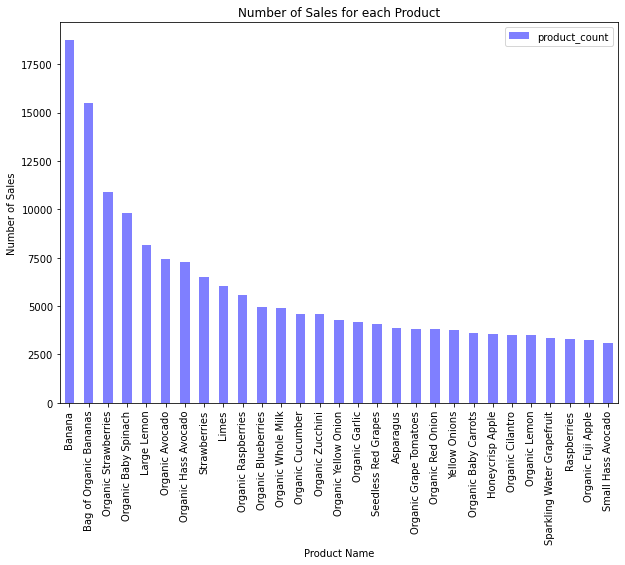

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

top_products_pd = top_products.toPandas()
pl = top_products_pd.plot(kind="bar", 
                            x="product_name", y="product_count", 
                            figsize=(10, 7),  alpha=0.5, color="blue")
pl.set_xlabel("Product Name")
pl.set_ylabel("Number of Sales")
pl.set_title("Number of Sales for each Product")

In [ ]:
from pyspark.sql import functions as F
grouped_orders = order_product.groupby("order_id").agg(F.collect_set("product_id").alias("product_ids"),F.collect_set("product_name").alias("product_names"))

In [ ]:
grouped_orders.take(5)

[Row(order_id=1, product_ids=[49683, 43633, 11109, 47209, 10246, 22035, 49302, 13176], product_names=['Bag of Organic Bananas', 'Cucumber Kirby', 'Lightly Smoked Sardines in Olive Oil', 'Organic 4% Milk Fat Whole Milk Cottage Cheese', 'Organic Whole String Cheese', 'Organic Celery Hearts', 'Organic Hass Avocado', 'Bulgarian Yogurt']),
 Row(order_id=96, product_ids=[20574, 39275, 30391, 40706, 27966, 25610, 24489], product_names=['Roasted Turkey', 'Organic Cucumber', 'Organic Raspberries', 'Organic Whole Strawberries', 'Organic Grape Tomatoes', 'Organic Pomegranate Kernels', 'Organic Blueberries']),
 Row(order_id=112, product_ids=[27104, 4549, 9047, 22425, 29217, 11776, 38273, 47209, 5876, 21174, 41860], product_names=['Umcka Elderberry Intensive Cold + Flu Berry Flavor', 'Fresh Cauliflower', 'I Heart Baby Kale', 'Hickory Honey Barbeque Baked Potato Chips', 'Sea Salt Baked Potato Chips', 'Premium Epsom Salt', 'Baked Sea Salt & Vinegar Potato Chips', 'Organic Hass Avocado', 'Organic Lemo

## Concept:  Caching
Caching in Spark is a very important concept which should be used carefully and efficiently as and when required. <br>
An RDD/DF is re-evaluated each time an action is called on it, if you cache that RDD/DF, it will be cached and stored in the specified memory, so that when you want to do repeated calls on some RDDs or DFs they are fast and optimized <br>
These are highly useful when you are using some RDD or DF iteratively for example in a loop.<br>
You should be careful while caching and use it only when required, else you are bound to OOM exceptions.


In [ ]:
grouped_orders.cache()

DataFrame[order_id: int, product_ids: array<int>, product_names: array<string>]

In [ ]:
%time grouped_orders.collect()

CPU times: user 1.73 s, sys: 392 ms, total: 2.12 s
Wall time: 16.9 s


[Row(order_id=1342, product_ids=[30827, 3798, 14966, 21137, 46129, 33081, 13176, 7862], product_names=['Raw Shrimp', 'Seedless Cucumbers', 'Versatile Stain Remover', 'Organic Strawberries', 'Organic Mandarins', 'Chicken Apple Sausage', 'Pink Lady Apples', 'Bag of Organic Bananas']),
 Row(order_id=1591, product_ids=[48246, 44116, 24852, 5194, 9130, 48823, 46473, 40310, 32520, 22105, 16900, 27681, 4103, 44008, 17758, 41671, 25316, 45061, 38805, 48205, 25237, 19604, 5384, 27344, 17203, 18792, 12986, 39758, 34358, 31215, 9387], product_names=['Cracked Wheat', 'Strawberry Rhubarb Yoghurt', 'Organic Bunny Fruit Snacks Berry Patch', 'Goodness Grapeness Organic Juice Drink', 'Honey Graham Snacks', 'Spinach', 'Granny Smith Apples', 'Oven Roasted Turkey Breast', 'Pure Vanilla Extract', 'Chewy 25% Low Sugar Chocolate Chip Granola', 'Banana', 'Original Turkey Burgers Smoke Flavor Added', 'Twisted Tropical Tango Organic Juice Drink', 'Navel Oranges', 'Lower Sugar Instant Oatmeal  Variety', 'Ultra T

In [ ]:
%time grouped_orders.collect()

CPU times: user 2.5 s, sys: 492 ms, total: 2.99 s
Wall time: 5.1 s


[Row(order_id=1342, product_ids=[30827, 3798, 14966, 21137, 46129, 33081, 13176, 7862], product_names=['Raw Shrimp', 'Seedless Cucumbers', 'Versatile Stain Remover', 'Organic Strawberries', 'Organic Mandarins', 'Chicken Apple Sausage', 'Pink Lady Apples', 'Bag of Organic Bananas']),
 Row(order_id=1591, product_ids=[48246, 44116, 24852, 5194, 9130, 48823, 46473, 40310, 32520, 22105, 16900, 27681, 4103, 44008, 17758, 41671, 25316, 45061, 38805, 48205, 25237, 19604, 5384, 27344, 17203, 18792, 12986, 39758, 34358, 31215, 9387], product_names=['Cracked Wheat', 'Strawberry Rhubarb Yoghurt', 'Organic Bunny Fruit Snacks Berry Patch', 'Goodness Grapeness Organic Juice Drink', 'Honey Graham Snacks', 'Spinach', 'Granny Smith Apples', 'Oven Roasted Turkey Breast', 'Pure Vanilla Extract', 'Chewy 25% Low Sugar Chocolate Chip Granola', 'Banana', 'Original Turkey Burgers Smoke Flavor Added', 'Twisted Tropical Tango Organic Juice Drink', 'Navel Oranges', 'Lower Sugar Instant Oatmeal  Variety', 'Ultra T

# Homework

Answer the following questions in Campuswire. Please include both code and answer. 

### 1. What are  the 10 Most common products


##### We need to count the number of times each product is repeated in the order_product dataframe. This can be done by simple group by clause. 

In [17]:
order_product.groupby('product_name').agg(count("*").alias('product_count')).sort('product_count',ascending=False).select('product_name').show(10,truncate=False)

+----------------------+
|product_name          |
+----------------------+
|Banana                |
|Bag of Organic Bananas|
|Organic Strawberries  |
|Organic Baby Spinach  |
|Large Lemon           |
|Organic Avocado       |
|Organic Hass Avocado  |
|Strawberries          |
|Limes                 |
|Organic Raspberries   |
+----------------------+
only showing top 10 rows



### 2.  How many items do people buy on average ?


##### The approach is simple. First calculate number of items in each order using a group by clause. This will give us both: the number of items in an order and unique list of orders. Then we add all the counts divided by the number of orders.

In [20]:
order_agg = order_product.groupby('order_id').agg(count("product_id").alias('order_count')).sort('order_count',ascending=False)

In [21]:
total_orders = order_agg.select('order_count').groupBy().sum().collect()[0][0]

In [22]:
order_counts = order_product.select('order_id').distinct().count()

In [23]:
average_number_of_items = total_orders/order_counts

On an avergare there are 10.55 items in each order. 

In [24]:
average_number_of_items

10.552759338155157

## 3. Percent organic products in the order vs not organic?



##### There are three steps in this question.
1. We need to calculate the number of organic products.
2. We need to calculate the number of non-organic products.
3. We need to calculate the percentage of organic products. 

In [25]:
label_organic = order_product.filter(lower(col("product_name")).contains("organic")).count()

In [26]:
label_non_organic = order_product.filter(~lower(col("product_name")).contains("organic")).count()

In [27]:
label_organic

405617

In [28]:
label_non_organic

979000

In [29]:
percent_of_organic_products = (label_organic/(label_organic+label_non_organic))*100

In [30]:
percent_of_non_organic_products = 100 - percent_of_organic_products

In [31]:
percent_of_organic_products

29.294526934163024

In [32]:
percent_of_non_organic_products

70.70547306583697

##### Organic products constitute of 29.30% while the non-organic consist of 70.70%.

### 4. Other interesting analysis.  
In the dataset we can observe that there are items in the order which are reordered and there are some items which are added by the user for the first time. This makes me think how many items are reordered in an order.


##### I have counted the number of items in each order which are reordered and then counted the number of items in each order which are added for the first time. 

In [ ]:
reorder = order_product.filter(col('reordered').eqNullSafe(1)).groupby('order_id').agg(count("*").alias('Reorder Items')).sort('Reorder Items',ascending=False)

In [ ]:
new_order = order_product.filter(col('reordered').eqNullSafe(0)).groupby('order_id').agg(count("*").alias('New Items')).sort('New Items',ascending=False)

In [ ]:
type(reorder)

pyspark.sql.dataframe.DataFrame

##### I have then joined the two RDDs and calculated the percentage of reordered items in each order. 

In [ ]:
new_rdd = new_order.join(reorder, ['order_id'])

In [ ]:
new_rdd = new_rdd.withColumn('Total Items', new_rdd[1]+new_rdd[2]).sort('Total Orders',ascending=False)

In [ ]:
new_rdd = new_rdd.withColumn('Percentage Reorder', round(new_rdd[2]*100/new_rdd[3]))

##### Now i have calulated number of orders in each percentage. I have then plotted a line graph. 

In [ ]:
final_rdd = new_rdd.groupBy('Percentage Reorder').agg(count("*").alias('Count')).sort('Percentage Reorder', ascending=True).toPandas()

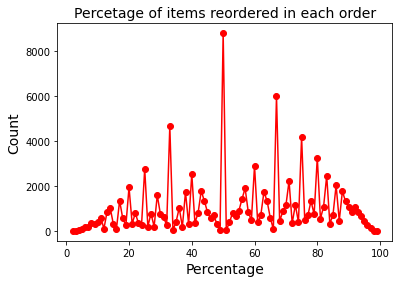

In [ ]:
plt.plot(final_rdd['Percentage Reorder'], final_rdd['Count'], color='red', marker='o')
plt.title('Percetage of items reordered in each order', fontsize=14)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(False)
plt.show()

##### In the above chart we can see that there are very few orders which have new items and reordered items. We can see that in most of the orders 50% items are reordered and 50% are newly added. 